## Introduction
The goal of this project is to use deep learning to perform image classification. More specifically, this project will use deep learning to classify kitchen sinks from bathroom sinks. This was a class project fo SI 670 at University of Michigan and all the images were sourced from the students in the class.

This project uses a pretrained model to aid with the classification task and closely follows this [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

#### The final predictions from this project were evaluated on Kaggle as part of the project. Using this notebook, our team achieved **98%** accuracy.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Loading the data

In [4]:
train_dir = "images_train/images_train"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=.2,
                                                            subset='both',
                                                            seed=1337)

Found 616 files belonging to 2 classes.
Using 493 files for training.
Using 123 files for validation.


Example of images and labels from the training set:

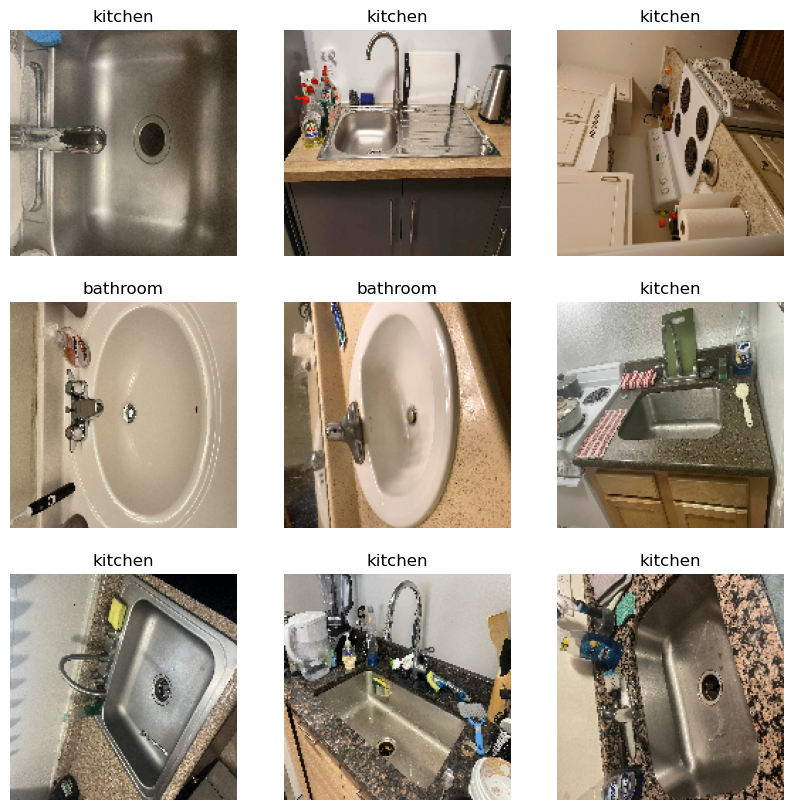

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Creating a test set.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Augmenting the data

Increasing the size of the dataset by randomly flipping and rotating images.

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

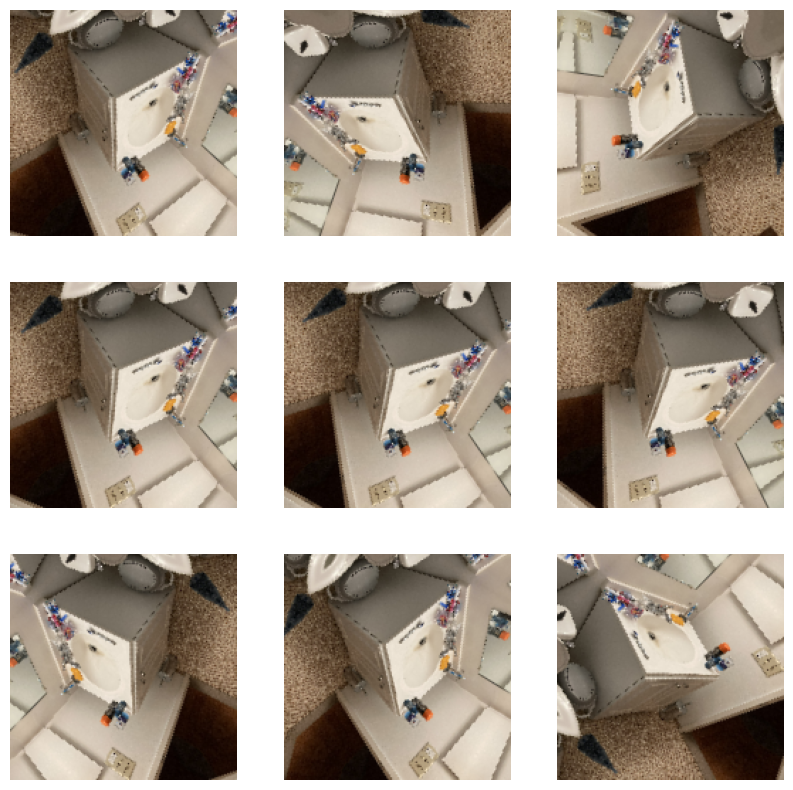

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Using pre-trained convnets
This project uses **MobileNet V2** (developed by Google) as a base model. This does not use the top classification layer since the goal is to use this pretrained model for feature extraction.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction

### Freeze the convolutional base

In [17]:
base_model.trainable = False

### Important note about BatchNormalization layers

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Adding a classification head

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Adding a prediction layer.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compiling the model


In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
len(model.trainable_variables)

2

### Training the model

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 5s 865ms/step - loss: 0.9545 - accuracy: 0.4146


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.41


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
16/16 [==============================] - 20s 800ms/step - loss: 0.9089 - accuracy: 0.4625 - val_loss: 0.8831 - val_accuracy: 0.4228
Epoch 2/10
16/16 [==============================] - 17s 746ms/step - loss: 0.8503 - accuracy: 0.5010 - val_loss: 0.8397 - val_accuracy: 0.4634
Epoch 3/10
16/16 [==============================] - 17s 759ms/step - loss: 0.8123 - accuracy: 0.4909 - val_loss: 0.8011 - val_accuracy: 0.4715
Epoch 4/10
16/16 [==============================] - 17s 751ms/step - loss: 0.7768 - accuracy: 0.5132 - val_loss: 0.7724 - val_accuracy: 0.4959
Epoch 5/10
16/16 [==============================] - 17s 751ms/step - loss: 0.7205 - accuracy: 0.5740 - val_loss: 0.7432 - val_accuracy: 0.5122
Epoch 6/10
16/16 [==============================] - 17s 748ms/step - loss: 0.7005 - accuracy: 0.5801 - val_loss: 0.7155 - val_accuracy: 0.5366
Epoch 7/10
16/16 [==============================] - 16s 741ms/step - loss: 0.6451 - accuracy: 0.6329 - val_loss: 0.6877 - val_accuracy: 0.5447

### Learning curves

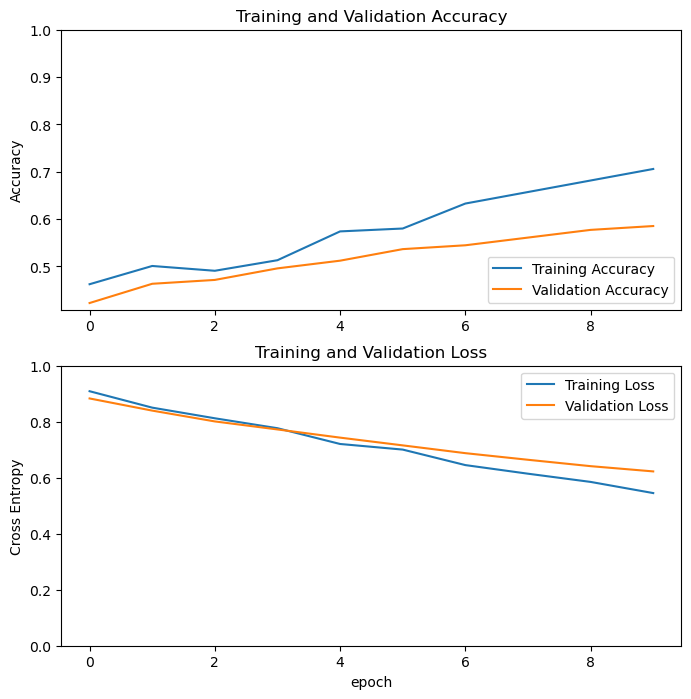

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freezing the top layers of the model


In [29]:
base_model.trainable = True

In [30]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

Lowered the learning rate due to the increased side of the model.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
len(model.trainable_variables)

56

### Continuing to train the model

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
16/16 [==============================] - 23s 891ms/step - loss: 0.3949 - accuracy: 0.8174 - val_loss: 0.3832 - val_accuracy: 0.8049
Epoch 11/20
16/16 [==============================] - 19s 875ms/step - loss: 0.2291 - accuracy: 0.9148 - val_loss: 0.2989 - val_accuracy: 0.9024
Epoch 12/20
16/16 [==============================] - 19s 889ms/step - loss: 0.1589 - accuracy: 0.9473 - val_loss: 0.2268 - val_accuracy: 0.8943
Epoch 13/20
16/16 [==============================] - 18s 828ms/step - loss: 0.1224 - accuracy: 0.9635 - val_loss: 0.2084 - val_accuracy: 0.8862
Epoch 14/20
16/16 [==============================] - 19s 931ms/step - loss: 0.1178 - accuracy: 0.9513 - val_loss: 0.1592 - val_accuracy: 0.9350
Epoch 15/20
16/16 [==============================] - 19s 857ms/step - loss: 0.1174 - accuracy: 0.9452 - val_loss: 0.1689 - val_accuracy: 0.9512
Epoch 16/20
16/16 [==============================] - 19s 877ms/step - loss: 0.0862 - accuracy: 0.9615 - val_loss: 0.1571 - val_accuracy:

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

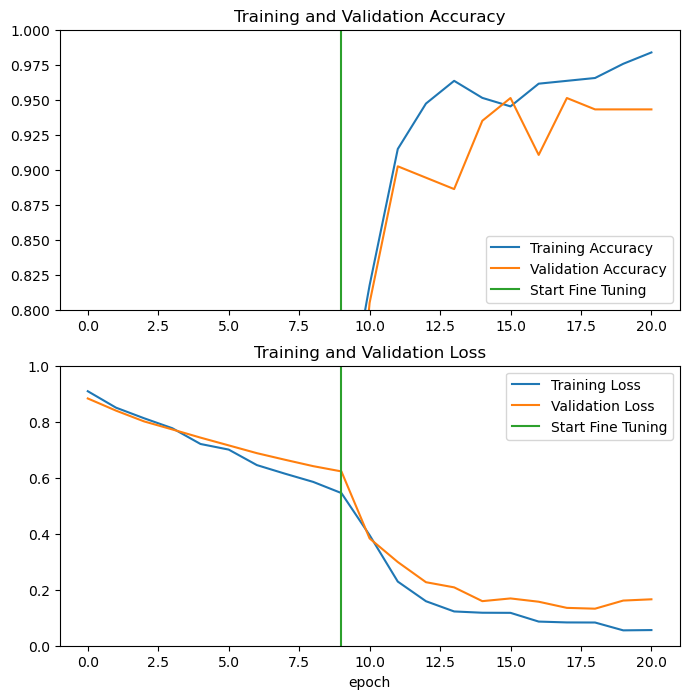

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction

In this step the model will be used to predict labels for previously unseen sinks. The predictions were output in a format suited for the Kaggle competition this project was built around.

In [39]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images_test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 149 files belonging to 1 classes.


In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

5/5 [==============================] - 4s 724ms/step
Predictions:
 [1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1
 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1
 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0
 1]


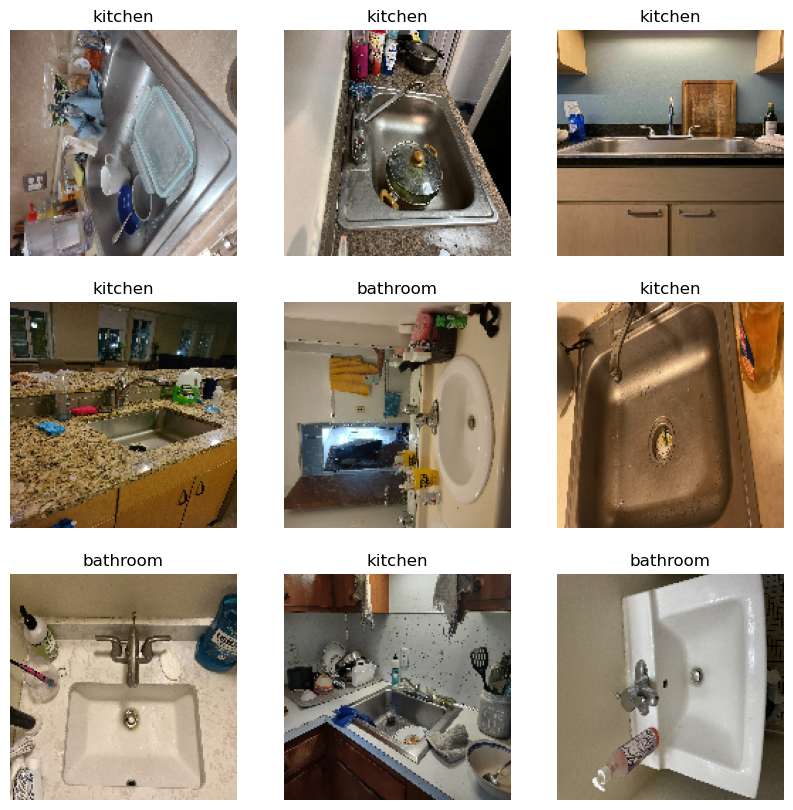

In [41]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = model.predict(test_dataset).flatten()


# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [42]:
# predictions = model.predict(test_dataset).flatten()
predictions

<tf.Tensor: shape=(149,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])>

In [43]:
import pandas as pd
ids = list(range(100,175))
ids2 = list(range(200,274))
for i in ids2:
    ids.append(i)
preds = predictions.numpy()

to_df = {'id': ids, 'class': preds}

pred_df = pd.DataFrame(data=to_df)
pred_df.head(5)

,id,class
0,100,1
1,101,1
2,102,1
3,103,1
4,104,0


In [44]:
pred_df['old_lab'] = pred_df['class']
pred_df.head(5)

,id,class,old_lab
0,100,1,1
1,101,1,1
2,102,1,1
3,103,1,1
4,104,0,0


In [45]:
pred_df['class'].mask(pred_df['old_lab'] == 0 , 1 , inplace=True)
pred_df['class'].mask(pred_df['old_lab'] == 1 , 0 , inplace=True)
pred_df.head(5)

,id,class,old_lab
0,100,0,1
1,101,0,1
2,102,0,1
3,103,0,1
4,104,1,0


In [46]:
final = pred_df[['id', 'class']]
final.head(5)

,id,class
0,100,0
1,101,0
2,102,0
3,103,0
4,104,1


In [47]:
final.to_csv('image_prediction10.csv', index=False)